## COMMUNITIES AND CRIME dataset experiment


### (1) Getting imports and definitions
#### (libraries and functions)

In [80]:
# Imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import time

""" 
SS GP algorithm functions
"""

import os
os.chdir('C:/Users/hughw/Documents/MSC project/GP algorithms/Master function files')
from GP_funcs_ZTMFSS import kernel_funcs
from GP_funcs_ZTMFSS import model_funcs
from GP_funcs_ZTMFSS import draw_GP
from GP_funcs_ZTMFSS import fit
from GP_funcs_ZTMFSS import diagnostics
from GP_funcs_ZTMFSS import simulations
from functools import partial
os.chdir('C:/Users/hughw/Documents/MSC project/Real data')

"""
Importing in rpy2
"""

os.environ['R_USER'] = 'D:\Anaconda3\Lib\site-packages\rpy2'
import rpy2
print(rpy2.__version__)
import rpy2.robjects as robjects

from rpy2.robjects.packages import importr
# import R's "base" package
base = importr('base')
base.R_home()
# import R's "utils" package
utils = importr('utils')

# import rpy2's package module
import rpy2.robjects.packages as rpackages

# import R's utility package
utils = rpackages.importr('utils')

# select a mirror for R packages
utils.chooseCRANmirror(ind=1) # select the first mirror in the list

# Function definitions for comparators - MAKE IT SO THEY ALWAYS JUST RETURN PREDICTIONS AND CLASSIFICATIONS
"""
Importing in requirements for SVGP Pytorch
"""
import tqdm
import math
import torch
import gpytorch

"""
Defining procedure to run SVGP
"""

from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy
from torch.utils.data import TensorDataset, DataLoader

def SVGP_train(y, X, lengthscale_init = 10, num_inducing=100, epochs=100, batch_size=100, learn_rate_variational = 0.1, learn_rate_hyper = 0.01, tol = 1e-4,seed=0, min_epochs = 100
              , alpha = 0.05, print_=False):
    
    # setting dimensions
    ntrain,ntest, p = len(y), len(X), len(X.T)
    
    # loading in data
    train_dataset = TensorDataset(X, y)
    train_loader = DataLoader(train_dataset, batch_size, shuffle=True)

    # Creating model
    class GPModel(ApproximateGP):
        def __init__(self, inducing_points):
            variational_distribution = gpytorch.variational.NaturalVariationalDistribution(inducing_points.size(0))
            variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
            super(GPModel, self).__init__(variational_strategy)
            self.mean_module = gpytorch.means.ConstantMean()
            self.covar_module = gpytorch.kernels.ScaleKernel(base_kernel=gpytorch.kernels.RBFKernel(ard_num_dims = p))

            # Initialize lengthscale
            if np.any(lengthscale_init):
                self.covar_module.base_kernel.lengthscale = np.ones(p)*lengthscale_init

        def forward(self, x):
            mean_x = self.mean_module(x)
            covar_x = self.covar_module(x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    np.random.seed(seed)
    inducing_points = X[np.random.choice(ntrain,num_inducing,False), :]
    model = GPModel(inducing_points=inducing_points)
    likelihood = gpytorch.likelihoods.GaussianLikelihood()

    if torch.cuda.is_available():
        model = model.cuda()
        likelihood = likelihood.cuda()

        num_epochs = epochs

    # Setting up model training
    t = time.time()
    torch.manual_seed(seed)
    model.train()
    likelihood.train()
    
    variational_ngd_optimizer = gpytorch.optim.NGD(model.variational_parameters(), num_data=train_y.size(0), lr=learn_rate_variational)

    hyperparameter_optimizer = torch.optim.Adam([
        {'params': model.hyperparameters()},
        {'params': likelihood.parameters()},
    ], lr=learn_rate_hyper)

    mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_y.size(0))
    
    # Setting up convergence criteria
    epochs_iter = tqdm.notebook.tqdm(range(epochs), desc="Epoch")
    i = 0
    param_diff=1
    loss_diff=1
    param = 1/model.covar_module.base_kernel.lengthscale
    
    # Training model
    while (i < epochs and loss_diff>0) or i<min_epochs:
        
        # Within each iteration, we will go over each minibatch of data
        minibatch_iter = tqdm.notebook.tqdm(train_loader, desc="Minibatch", leave=False)
        for x_batch, y_batch in minibatch_iter:
            
            ### Perform NGD step to optimize variational parameters
            variational_ngd_optimizer.zero_grad()
            output = model(x_batch)
            loss = -mll(output, y_batch)
            minibatch_iter.set_postfix(loss=loss.item())
            loss.backward()
            variational_ngd_optimizer.step()

            ### Perform Adam step to optimize hyperparameters
            hyperparameter_optimizer.zero_grad()
            output = model(x_batch)
            loss = -mll(output, y_batch)
            loss.backward()
            hyperparameter_optimizer.step()
        
        # Update convergence criteria
        i+=1
        param_old = param
        param = 1/model.covar_module.base_kernel.lengthscale
        param_diff = np.mean(np.abs((param-param_old).detach().numpy()))
        if i==1:
            loss_new = loss.item()
        else:
            loss_old = loss_new
            loss_new = loss.item()*alpha+(1-alpha)*loss_old
            loss_diff = loss_old - loss_new
        
        numprint = min(10,p)
        if print_:
            print(np.sort(model.covar_module.base_kernel.lengthscale.detach().numpy())[0][:numprint])
            print(loss_new, param_diff)
    print("Runtime is ", time.time()-t)
    
    return model, loss, likelihood

def SVGP_test(model,likelihood, ytest, Xtest, batch_size=100):

    test_dataset = TensorDataset(Xtest, ytest)
    test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

    # Getting model evaluations
    model.eval()
    likelihood.eval()
    means = torch.tensor([0.])
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            preds = model(x_batch)
            means = torch.cat([means, preds.mean.cpu()])
    means = means[1:]
    
    print('Test MSE: {}'.format(torch.mean(torch.abs(means - ytest.cpu())**2)))
    
    return means

"""
Defining procedure to run SGP
"""

from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel, InducingPointKernel
from gpytorch.distributions import MultivariateNormal

def SGP_train(y, X, lengthscale_init = 10, num_inducing=100, iterations=100, learn_rate = 0.1, tol = 1e-4, seed=0, min_iterations = 100, alpha = 0.05, print_=False):
    
    # setting dimensions
    ntrain,ntest, p = len(y), len(X), len(X.T)

    # Creating model
    
    class GPRegressionModel(gpytorch.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood, inducing_points):
            super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = ConstantMean()
            self.base_covar_module = ScaleKernel(RBFKernel(ard_num_dims = p))
            self.covar_module = InducingPointKernel(self.base_covar_module, inducing_points=inducing_points, likelihood=likelihood)

            # Initialize lengthscale
            if np.any(lengthscale_init):
                self.base_covar_module.base_kernel.lengthscale = np.ones(p)*lengthscale_init

        def forward(self, x):
            mean_x = self.mean_module(x)
            covar_x = self.covar_module(x)
            return MultivariateNormal(mean_x, covar_x)

        np.random.seed(seed)
    
    inducing_points = X[np.random.choice(ntrain,num_inducing,False), :]
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = GPRegressionModel(train_x, train_y, likelihood, inducing_points)

    if torch.cuda.is_available():
        model = model.cuda()
        likelihood = likelihood.cuda()

    # Setting up model training
    t = time.time()
    torch.manual_seed(seed) 
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    
    # Setting up convergence criteria
    i = 0
    param_diff=1
    loss_diff=1
    param = 1/model.base_covar_module.base_kernel.lengthscale
    
    # Training model
    while (i < iterations and loss_diff>0) or i<min_iterations:
        
        # Zero backprop gradients
        optimizer.zero_grad()
        # Get output from model
        output = model(train_x)
        # Calc loss and backprop derivatives
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()
        torch.cuda.empty_cache()
        
        # Update convergence criteria
        i+=1
        param_old = param
        param = 1/model.base_covar_module.base_kernel.lengthscale
        param_diff = np.mean(np.abs((param-param_old).detach().numpy()))
        if i==1:
            loss_new = loss.item()
        else:
            loss_old = loss_new
            loss_new = loss.item()*alpha+(1-alpha)*loss_old
            loss_diff = loss_old - loss_new
        
        numprint = min(10,p)
        if not i % 1:
            if print_:
                print(np.sort(model.base_covar_module.base_kernel.lengthscale.detach().numpy())[0][:numprint])
                print(loss_new, param_diff)
                print('Iter %d - Loss: %.3f' % (i + 1, loss.item()))
    print("Runtime is ", time.time()-t)
    
    return model, loss, likelihood

def SGP_test(model,likelihood, ytest, Xtest):
    
    # Getting model evaluations
    model.eval()
    likelihood.eval()
    with gpytorch.settings.max_preconditioner_size(10), torch.no_grad():
        preds = model(Xtest)
    
    print('Test MSE: {}'.format(torch.mean(torch.abs(preds.mean - ytest.cpu())**2)))
    
    return preds.mean

3.4.5


### (2) Getting data 
#### (takes in a file and outputs cleaned data y, X)

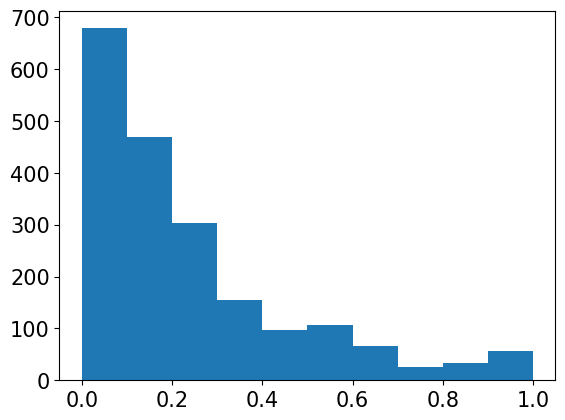

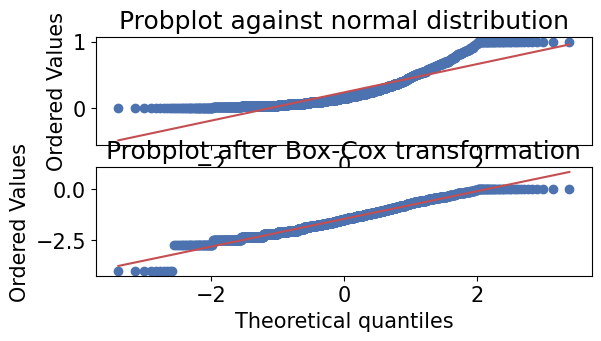

dimensions are :  (1993, 100)


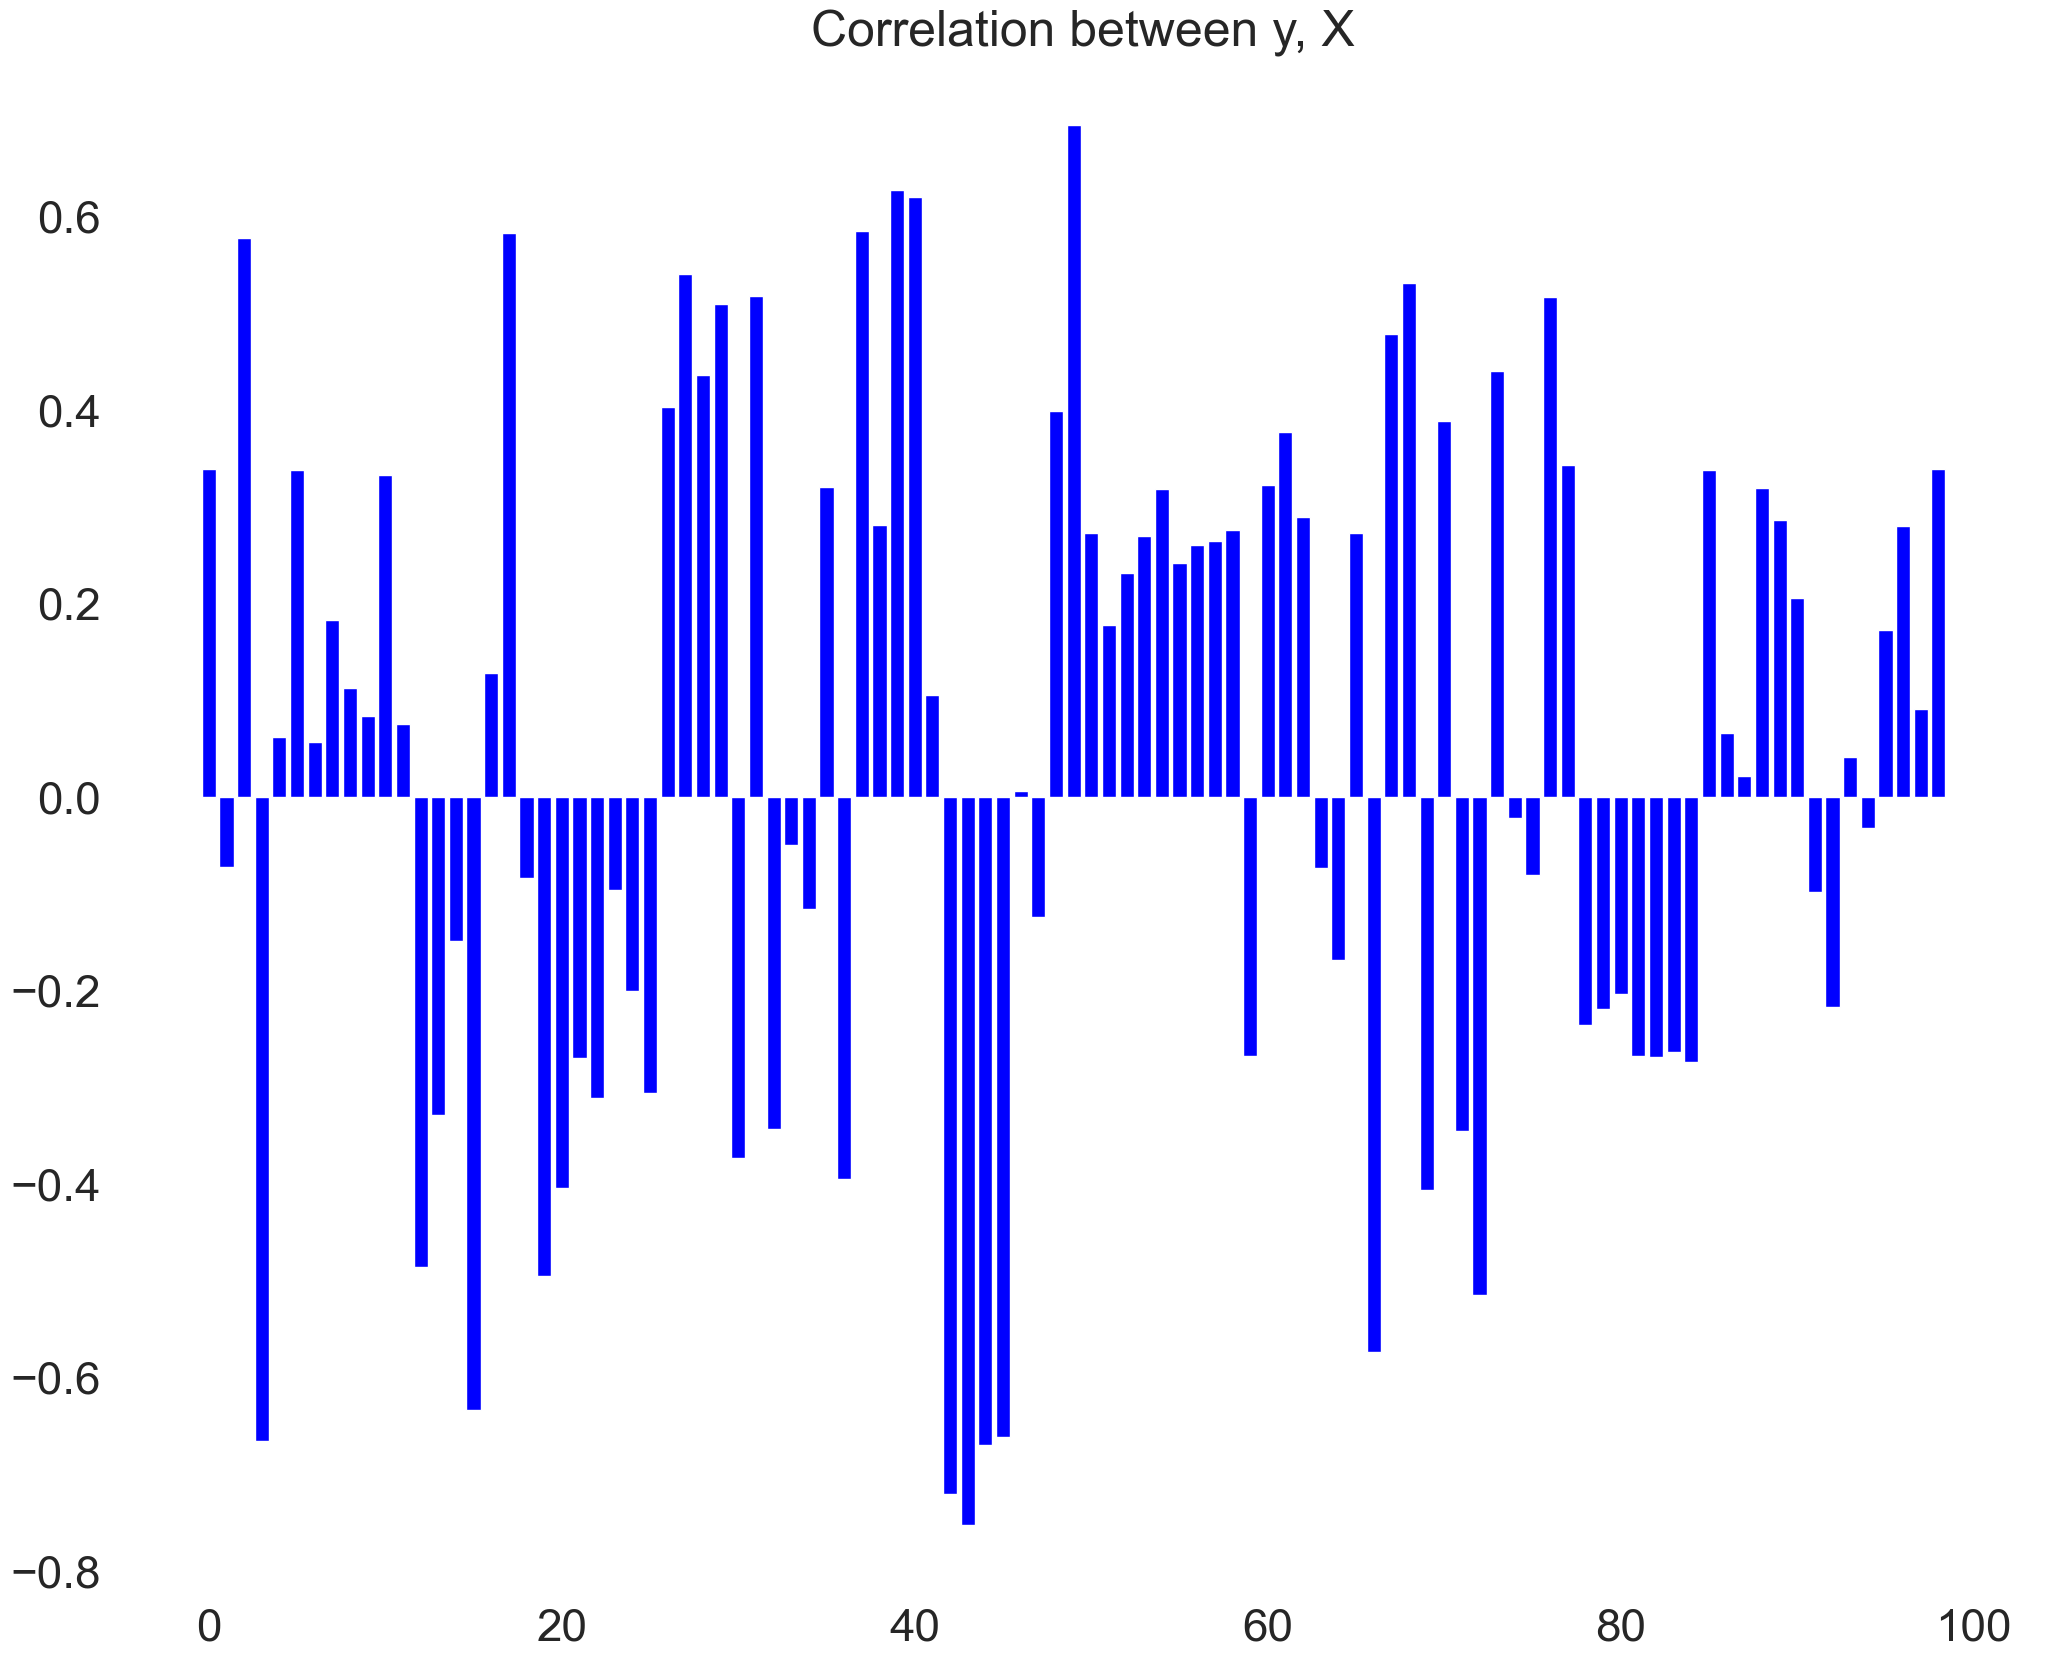

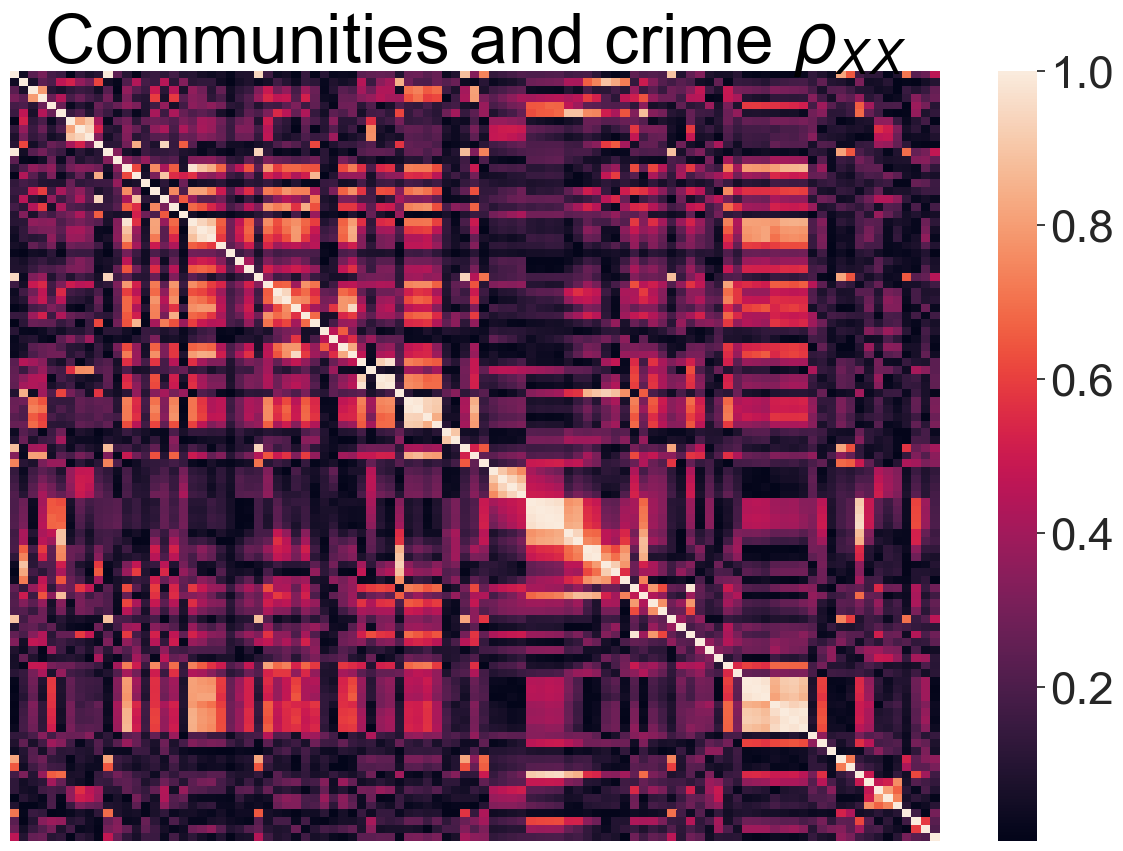

In [97]:
# Inputting raw data
from matplotlib import rcParams, rc_file_defaults
rc_file_defaults()
plt.rc('axes',edgecolor='black')
font = {'family' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.rcParams.update({'text.color' : "black",
                      'xtick.color' : "black",
                      'ytick.color' : "black",
                     'axes.labelcolor' : "black"})

df = pd. read_csv ("communities.txt", sep=",") 
data = np.array(df)

# Box cox transformations to dependent
y = data[:,len(data.T)-1].astype(float)
plt.hist(y)

fig = plt.figure()
ax1 = fig.add_subplot(311)
prob = stats.probplot(y, dist=stats.norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Probplot against normal distribution')

ax2 = fig.add_subplot(312)
yt, _ = stats.boxcox(y+1e-10)
prob = stats.probplot(yt, dist=stats.norm, plot=ax2)
ax2.set_title('Probplot after Box-Cox transformation')
plt.show()

# Counting NAs and removing NA columns 
NA_ind = data[:,5:]=='?'
NA_rowcount = np.sum(NA_ind, 0)
D = data[:,5:][:,NA_rowcount==0].astype(float)
print("dimensions are : ", np.shape(D))

# Getting correlations
n,p = np.shape(D)
d = p-1
corrxy = np.zeros(p)
for i in range(len(D.T)-1):
     corrxy[i]=np.corrcoef(D[:,i],yt)[0,1]
sns.set(font_scale = 3)
fig,axs = plt.subplots(figsize = (25,20))
fig.set_facecolor('white')
axs.set_facecolor('white')
plt.bar(range(p),height = corrxy, color = "blue")
plt.title("Correlation between y, X")
plt.show()
fig.savefig("CorryX_communities")
fig,axs = plt.subplots(figsize = (15,10))
sns.heatmap(np.abs(np.corrcoef(D[:,:len(D.T)-1].T)), label = "Correlation matrix", yticklabels = False, xticklabels = False, color = "black")
plt.title(r"Communities and crime $\rho_{XX}$", fontsize = 50, color = "black")
fig.savefig("CorrX_communities")

# get y, X
y = yt
X = D[:,:len(D.T)-1]

### (3) Setting up experiment dimensions 
#### (determine random train:test splits and set up storage objects)

In [21]:
# Train:test splitting settings
n_replications = 20
ntrain = int(0.8*n)
ntest = n - ntrain
nmodel = 3

# Model settings
minibatch = 256
nns=256
learn_rate = 0.0025
sampling_strat = "nn"
min_VBEM_iter = 3
max_VBEM_iter = 5
gp_iters = 200
VBEM_tol = 0.1/d
kern = kernel_funcs.gaussian
grad_kern = kernel_funcs.grad_gaussian
post_var = False
post_cov = False
train_largest = True
folds = 2
MC=1000
learn_rate_mult = 1
spike = 1e+4
final_ELBO_sample = int(n/1000)
reg = 0.01
v_l0, v_l1, a,b = 1e+4,1e-4,1e-3,1e-3
ELBO_sample=1000
temp=1
Xscales = 2**np.linspace(np.log2(100),-np.log2(100),11)

# Storage objects
MSE = np.zeros((n_replications, nmodel))
Runtime = np.zeros((n_replications, nmodel))
L = np.zeros((n_replications, nmodel, d))
Lambda = np.zeros((n_replications, nmodel, d))

# Model choices
linear_models = False
MSE_hyperopt = True
SGPs = True
SSVGPs = True
predict_selected = True

### (4) Iterating over train:test splits

In [ ]:
# Code for NN preds and normal preds
#fpost_mean, fpost_var, ypost_mean, ypost_var = diagnostics.get_pred_posterior_GP_NN(ytrain,Xtrain,Xtest,results[0][0],results[1],results[2],reg=0.01,kern=kern,grad_kern =grad_kern,
#                                                                                NN=minibatch, select = results[3]>0.01,fraction = 1, grad_steps = 0, learn_rate = 0.1, tol = 1e-5, print_grad=False,pred_selected = False, latents = False)

In [96]:
# Loop start and object initialisation
for i in range(n_replications): 
    np.random.seed(i)
    
    shuffled_indexes = np.random.choice(n,n,False)
    y_shuffle = y[shuffled_indexes]
    X_shuffle = X[shuffled_indexes]
    
    if np.min(X_shuffle[:ntrain].var(0))>0:
    
    # Get current train:test split
        ytrain = ((y_shuffle[:ntrain]-y_shuffle[:ntrain].mean())/y_shuffle[:ntrain].var()**0.5).reshape(ntrain,1)
        ytest = ((y_shuffle[ntrain:]-y_shuffle[:ntrain].mean())/y_shuffle[:ntrain].var()**0.5).reshape(ntest,1)

        Xtrain = (X_shuffle[:ntrain] - X_shuffle[:ntrain].mean(0))/X_shuffle[:ntrain].var(0)**.5
        Xtest = (X_shuffle[ntrain:] - X_shuffle[:ntrain].mean(0))/X_shuffle[:ntrain].var(0)**.5

    # Run all SS-GP algorithms,  get predictions and store performance
    
    
        """
        ZTMF
        """
        m=0
        t= time.time()

        # Running algorithm
        results = fit.VB_EM_GP_SS(ytrain, Xtrain, l0 = 0.01, reg = 0.01, learn_rate = learn_rate, sampling_strat = sampling_strat, v0=spike, learn_spike = False, 
                              min_VBEM_iter=min_VBEM_iter,max_VBEM_iter = max_VBEM_iter, init_GP_iter = gp_iters, optimisation = "amsgrad",
                              subsample = minibatch, iter_remove = False, kern=kern, grad_kern = grad_kern, print_VBEM=False, seed=i, learn_rate_mult = 1,
                                 store_ls=False,print_GP_fit = False)
            
        # Getting predictions
        fpost_mean, fpost_var, ypost_mean, ypost_var = diagnostics.get_pred_posterior_GP(ytrain,Xtrain[:,results[3]>0.01],Xtest[:,results[3]>0.01],results[0][0][results[3]>0.01],results[1],results[2],reg=0.01,kern=kern, latents = False)
        MSE[i,m] = simulations.MSE_pc(ypost_mean,ytest)
        Runtime[i,m] = time.time()-t
        L[i,m,:] = results[0][0]
        Lambda[i,m,:] = results[3]
        print("MSE is : ", MSE[i,m])
        print("Runtime is : ", Runtime[i,m])

        """
        ZTMF-VS
        """
        m+=1
        t= time.time()

        # Running algorithm
        results = fit.VB_EM_GP_SS(ytrain, Xtrain, l0 = 0.01, reg = 0.01, learn_rate = learn_rate, sampling_strat = sampling_strat, v0=spike, learn_spike = False, 
                              min_VBEM_iter=min_VBEM_iter,max_VBEM_iter = max_VBEM_iter, init_GP_iter = gp_iters, optimisation = "amsgrad",
                              subsample = minibatch, iter_remove = True, kern=kern, grad_kern = grad_kern, print_VBEM=False, seed = i,learn_rate_mult = learn_rate_mult)
        
        # Getting predictions
        fpost_mean, fpost_var, ypost_mean, ypost_var = diagnostics.get_pred_posterior_GP(ytrain,Xtrain[:,results[3]>0.01],Xtest[:,results[3]>0.01],results[0][0][results[3]>0.01],results[1],results[2],reg=0.01,kern=kern, latents = False)
        MSE[i,m] = simulations.MSE_pc(ypost_mean,ytest)
        Runtime[i,m] = time.time()-t
        L[i,m,:] = results[0][0]
        Lambda[i,m,:] = results[3]
        print("MSE is : ", MSE[i,m])
        print("Runtime is : ", Runtime[i,m])


        """
        Initialising model weight vector
        """
        weights = np.zeros(10)

        """
        BMA over X_scale (iter_remove = 1)
        """
        m += 1
        t = time.time()

        # Running algorithm
        testing_algorithm = partial(diagnostics.get_pred_posterior_GP,reg = 0.01 ,kern = kern, latents = False)
        hyper_vals = [1e+4*Xscales,1e-4*Xscales]
        hyper_arg = ["v0","v1"]
        best_loss, best_val, losses, Results = fit.hyper_opt_SSGP(
                                            ytrain, Xtrain, fit.VB_EM_GP_SS, testing_algorithm, hyper_arg, hyper_vals, method =  "ML", folds = 5, metric = "elbo", 
                                            training_args=["final_ELBO_sample", "v0", "seed", "iter_remove", "print_VBEM", "learn_rate", "subsample", "sampling_strat", "min_VBEM_iter","init_GP_iter", "max_VBEM_iter", "GP_fit_tol", "VBEM_tol", "learn_rate_mult"], 
                                            training_arg_vals=[0, spike, i,        True,          False,      learn_rate,    minibatch,    sampling_strat ,  min_VBEM_iter, gp_iters,  max_VBEM_iter ,           1e-5,         0.1/d, learn_rate_mult])

        t1 = time.time()

        if MSE_hyperopt:
            # MSE WEIGHTING
            log_predictives = np.zeros(len(Results))
            for j in range(len(Results)):
                log_predictives[j] =  diagnostics.get_pred_posterior_GP_NN_CV(ytrain,Xtrain,Results[j],0.01,kern,NN=128, fraction=1,post_var=True, print_=False, use_tree=False, leaf_size=100, seed=0)
                print(j)
            
            train_time = time.time()-t
            
            testing_algorithm_ = partial(testing_algorithm,fraction = 1)      
            min_loss = np.max(log_predictives)
            weights = np.exp(log_predictives - min_loss)*(np.abs(log_predictives - min_loss)<=500)
            weights = weights/weights.sum()

            Lmbda = np.zeros((len(Results), d))
            Ls = np.zeros((len(Results), d))
            for j in range(len(Results)):
                Lmbda[j] = Results[j][3]
                Ls[j] = np.abs(Results[j][0][0])         
            PIP = Lmbda.T @ weights
            l = Ls.T @ weights

            BMA_preds = diagnostics.get_BMA_predictions(ytrain,Xtrain,Xtest,testing_algorithm, Results,weights, MC_samples=MC)
            MSE[i,m] = simulations.MSE_pc(BMA_preds[1],ytest)
            Runtime[i,m] = time.time()-t
            L[i,m,:] = l
            Lambda[i,m,:] = PIP
            print("MSE is : ", MSE[i,m])
            print("Runtime is : ", Runtime[i,m])
            m+=1
            
        t2 = time.time()

        # ELBO WEIGHTING
        elbos = np.zeros(len(Results))
        for j in range(len(Results)):
            r = Results[j]
            l = r[0][0]
            s = r[1]
            sig = r[2]
            lmbda = r[3]    
            select = l!=0
            logpi,log1_pi,ahat,bhat = r[len(r)-2]
            np.random.seed(0)
            for sample_ in range(final_ELBO_sample):
                elbos[j] += model_funcs.ELBO(l,s,sig,reg,ytrain,Xtrain,lmbda,logpi,log1_pi,v_l0,v_l1,ELBO_sample,a,ahat,b,bhat,kern,1,select, 1)/final_ELBO_sample  
        
        Lmbda = np.zeros((len(Results), d))
        Ls = np.zeros((len(Results), d))
        max_elbo = np.max(elbos)

        for j in range(len(Results)):
            elbo = elbos[j]
            if elbo < max_elbo-500:
                    weights[j]=0
            else:
                    weights[j] = np.exp(elbo-max_elbo)*(np.abs(elbo-max_elbo)<=500)
            Lmbda[j] = Results[j][3]
            Ls[j] = np.abs(Results[j][0][0])  

        weights = weights/weights.sum()
        PIP = Lmbda.T @ weights
        l = Ls.T @ weights
        BMA_preds = diagnostics.get_BMA_predictions(ytrain,Xtrain,Xtest,testing_algorithm, Results,weights, MC_samples=MC)
        MSE[i,m] = simulations.MSE_pc(BMA_preds[1],ytest)
        Runtime[i,m] = time.time()-t-(t2-t1)
        L[i,m,:] = l
        Lambda[i,m,:] = PIP
        print("MSE is : ", MSE[i,m])
        print("Runtime is : ", Runtime[i,m])

        """
        Temporarily saving data to file directory
        """

        if linear_models:
            os.chdir('C:/Users/hughw/Documents/MSC project/R scripts')
            np.save("y", ytrain)
            np.save("f", ytrain)
            np.save("X", Xtrain.reshape(ntrain*d,))
            np.save("ytest", ytest)
            np.save("ftest", ytest)
            np.save("Xtest", Xtest.reshape(ntest*d,))
            np.save("select", np.random.random(d)<0.5)

            """
            Linear models
            """
            m += 1
            r=robjects.r
            output = r.source("ncvreg_code_crime.R")
            Runtime[i,m:m+3]=output[0][0]
            MSE[i,m:m+3]=output[0][1]
            L[i,m:m+3,:]=np.array(output[0][2]).T

            """
            GAMS
            """
            m += 3
            r=robjects.r
            output = r.source("sparseGAM_code_crime.R")
            Runtime[i,m:m+3]=output[0][0]
            MSE[i,m:m+3]=output[0][1]
            L[i,m:m+3,:]=np.array(output[0][2]).T

            """
            SBGAM
            """
            m += 3
            r=robjects.r
            t = time.time()
            output = r.source("sparseBayesGAM_code_crime.R")
            Runtime[i,m]=time.time()-t
            MSE[i,m]=np.array(output[0][1])
            L[i,m,:]=np.array(output[0][2]).T

            os.remove("y.npy")
            os.remove("f.npy")
            os.remove("X.npy")
            os.remove("ytest.npy")
            os.remove("ftest.npy")
            os.remove("Xtest.npy")
            os.remove("select.npy")

        if SGPs:
            
                            
            """
            SGD GP
            """
            m += 1
            t= time.time()

            # Running algorithm
            results = fit.VB_EM_GP_SS(ytrain, Xtrain, l0 = 0.01, reg = 0.01, learn_rate = 0.01, sampling_strat = sampling_strat, v0=1e+4, learn_spike = False, 
                                  min_VBEM_iter=1,max_VBEM_iter = 1, init_GP_iter = 200, optimisation = "adam",
                                  subsample = 256, iter_remove = False, kern=kern, grad_kern = grad_kern, print_VBEM=False, seed=i)

            # Getting predictions
            fpost_mean, fpost_var, ypost_mean, ypost_var = diagnostics.get_pred_posterior_GP(ytrain,Xtrain,Xtest,results[0][0],results[1],results[2],reg=0.01,kern=kern, latents = False)
            MSE[i,m] = simulations.MSE_pc(ypost_mean,ytest)
            Runtime[i,m] = time.time()-t
            L[i,m,:] = results[0][0]
            Lambda[i,m,:] = results[3]
            print("MSE is : ", MSE[i,m])

            
            """
            SGP
            """
            m += 1
            Ys = ((y_shuffle-y_shuffle[:ntrain].mean())/y_shuffle[:ntrain].var()**0.5).reshape(n,1)
            Xs = ((X_shuffle-X_shuffle[:ntrain].mean(0))/X_shuffle[:ntrain].var(0)**0.5).reshape(n,d)
            Xtorch = torch.from_numpy(Xs).float()
            Ytorch = torch.from_numpy(Ys.reshape(ntrain+ntest,)).float()


            train_x = Xtorch[:ntrain, :]
            train_y = Ytorch[:ntrain]
            test_x = Xtorch[ntrain:, :]
            test_y = Ytorch[ntrain:]

            t = time.time()
            model,loss,likelihood = SGP_train(train_y, train_x, lengthscale_init = [], num_inducing=512, iterations=100, learn_rate = 0.1, 
                                        seed = 0, min_iterations=100, alpha = 0.01)
            preds = SVGP_test(model,likelihood,test_y, test_x, batch_size=512)
            Runtime[i,m] = time.time()-t
            MSE[i,m] = simulations.MSE_pc(np.array(preds),np.array(test_y))
            print("MSE is : ", MSE[i,m])
            print("Runtime is : ", Runtime[i,m])
            #L[i,m,:] = 1/model.covar_module.base_kernel.lengthscale.detach().numpy()[0]

            """
            SVGP
            """
            m += 1
            model,loss,likelihood = SVGP_train(train_y, train_x, lengthscale_init = [], num_inducing=1024, epochs=100, batch_size=1024, learn_rate_variational = 0.01, 
                                               learn_rate_hyper = 0.1, tol = 1e-3, seed = 0, min_epochs = 100, alpha = 0.01)

            preds = SVGP_test(model,likelihood,test_y, test_x, batch_size=1024)
            Runtime[i,m] = time.time()-t
            MSE[i,m] = simulations.MSE_pc(np.array(preds),np.array(test_y))
            L[i,m,:] = 1/model.covar_module.base_kernel.lengthscale.detach().numpy()[0]
            print("MSE is : ", MSE[i,m])
            print("Runtime is : ", Runtime[i,m])
            
        """
        BMS with MSE
        """
        if MSE_hyperopt:
            m += 1
            t1 = time.time()

            weights = (log_predictives==np.max(log_predictives))*1
            weights = weights/weights.sum()

            Lmbda = np.zeros((len(Results), d))
            Ls = np.zeros((len(Results), d))
            for j in range(len(Results)):
                Lmbda[j] = Results[j][3]
                Ls[j] = np.abs(Results[j][0][0])         
            PIP = Lmbda.T @ weights
            l = Ls.T @ weights

            BMA_preds = diagnostics.get_BMA_predictions(ytrain,Xtrain,Xtest,testing_algorithm, Results,weights, MC_samples=MC)
            MSE[i,m] = simulations.MSE_pc(BMA_preds[1],ytest)
            Runtime[i,m] = time.time()-t1+train_time
            L[i,m,:] = l
            Lambda[i,m,:] = PIP
            print("MSE is : ", MSE[i,m])
            print("Runtime is : ", Runtime[i,m])
            
        print("MSE mean is : ", MSE[:i+1].mean(0))
        print("Runtime mean is : ", Runtime[:i+1].mean(0))

run time is : 26.302176237106323
MSE is :  0.28147506922408355
Runtime is :  26.429440021514893
run time is : 13.153802394866943
MSE is :  0.28157688773850803
Runtime is :  13.285401821136475
run time is : 16.560319185256958
run time is : 16.17089819908142
run time is : 15.707791090011597
run time is : 15.240265846252441
run time is : 14.372872591018677
run time is : 13.358336687088013
run time is : 12.651061773300171
run time is : 11.989925384521484
run time is : 10.939197778701782
run time is : 9.940040588378906
0
1
2
3
4
5
6
7
8
9
10
MSE is :  0.2792091443387312
Runtime is :  159.87082719802856
MSE is :  0.2836584701597259
Runtime is :  137.8563997745514
run time is : 9.05474305152893
MSE is :  0.27851196632786024
Runtime is  20.851998567581177
Test MSE: 0.28209593892097473
MSE is :  0.28895628452301025
Runtime is :  20.898873329162598


Runtime is  243.3732669353485
Test MSE: 0.2748117744922638
MSE is :  0.28149494528770447
Runtime is :  264.3260040283203
MSE is :  0.2815768877385071
Runtime is :  158.92853474617004
MSE mean is :  [0.32435576 0.3262479  0.32197576 0.33978914 0.32360288 0.33044897
 0.32307792 0.32316965]
Runtime mean is :  [ 26.36309371  16.03978906 174.59495225 150.97505755   9.9849731
  21.60036378 288.02207866 173.53813696]
run time is : 27.920619010925293
MSE is :  0.377379706384534
Runtime is :  28.06124258041382
run time is : 14.137831926345825
MSE is :  0.37737678551901344
Runtime is :  14.284378051757812
run time is : 18.015678882598877
run time is : 17.59156823158264
run time is : 16.91991376876831
run time is : 16.04213285446167
run time is : 15.091634750366211
run time is : 13.969761371612549
run time is : 12.004477500915527
run time is : 11.39584469795227
run time is : 11.672114849090576
run time is : 9.929083824157715
0
1
2
3
4
5
6
7
8
9
10
MSE is :  0.37645488717997394
Runtime is :  166.2

Runtime is  251.0418381690979
Test MSE: 0.3936711847782135
MSE is :  0.3777984380722046
Runtime is :  271.6352574825287
MSE is :  0.37737678551900866
Runtime is :  165.29883694648743
MSE mean is :  [0.33319309 0.33476938 0.33105561 0.34830246 0.33182697 0.33839514
 0.33219801 0.33220417]
Runtime mean is :  [ 26.64611852  15.74722056 173.21004828 149.70464273   9.89070392
  21.42176859 285.29094179 172.16492029]
run time is : 28.248881340026855
MSE is :  0.31320731962567533
Runtime is :  28.396484851837158
run time is : 14.52739667892456
MSE is :  0.3131391485655313
Runtime is :  14.668442964553833
run time is : 17.97381281852722
run time is : 17.31727957725525
run time is : 16.941014051437378
run time is : 16.279325485229492
run time is : 15.562234878540039
run time is : 14.325615167617798
run time is : 13.149791717529297
run time is : 12.156246662139893
run time is : 10.476253271102905
run time is : 10.036042928695679
0
1
2
3
4
5
6
7
8
9
10
MSE is :  0.311576862353903
Runtime is :  16

Runtime is  243.4674515724182
Test MSE: 0.31814754009246826
MSE is :  0.31979843974113464
Runtime is :  264.6203866004944
MSE is :  0.31313914856552927
Runtime is :  167.08959293365479
MSE mean is :  [0.33033798 0.33167935 0.32827293 0.34499561 0.32960758 0.33506658
 0.33042664 0.3294806 ]
Runtime mean is :  [ 26.89617085  15.59310947 172.46195265 149.0414475    9.84264578
  21.37524264 282.33800534 171.43987353]
run time is : 28.043920516967773
MSE is :  0.3114003931251416
Runtime is :  28.180555820465088
run time is : 14.583305358886719
MSE is :  0.3114343877813882
Runtime is :  14.722833395004272
run time is : 17.994364738464355
run time is : 17.3418447971344
run time is : 16.684803009033203
run time is : 16.257211923599243
run time is : 15.443236351013184
run time is : 14.259008407592773
run time is : 12.719794273376465
run time is : 12.031144142150879
run time is : 11.057256698608398
run time is : 10.294533252716064
0
1
2
3
4
5
6
7
8
9
10
MSE is :  0.3065626747743442
Runtime is : 

Runtime is  242.68059182167053
Test MSE: 0.34462693333625793
MSE is :  0.30999934673309326
Runtime is :  263.4110953807831
MSE is :  0.3084724993218498
Runtime is :  166.70312213897705
MSE mean is :  [0.32797078 0.32914873 0.32555915 0.34356373 0.32729017 0.33240375
 0.32787323 0.32685458]
Runtime mean is :  [ 27.05671898  15.48432496 171.84749824 148.53830606   9.94751012
  21.28729492 279.97214159 170.8477796 ]
run time is : 27.89563798904419
MSE is :  0.3714993112406618
Runtime is :  28.03502607345581
run time is : 14.215627908706665
MSE is :  0.3717357085137918
Runtime is :  14.357283115386963
run time is : 16.894356966018677
run time is : 19.17842388153076
run time is : 16.777847051620483
run time is : 15.733183860778809
run time is : 15.284541606903076
run time is : 13.971768140792847
run time is : 12.808372974395752
run time is : 10.769164323806763
run time is : 11.110501766204834
run time is : 10.13523817062378
0
1
2
3
4
5
6
7
8
9
10
MSE is :  0.36456421578234555
Runtime is :  

Runtime is  242.5726501941681
Test MSE: 0.38126420974731445
MSE is :  0.3785392940044403
Runtime is :  263.6848313808441
MSE is :  0.36489242347976475
Runtime is :  165.0464437007904
MSE mean is :  [0.33280728 0.33388062 0.32989305 0.34922917 0.33185158 0.33671716
 0.33350279 0.33108101]
Runtime mean is :  [ 27.16541976  15.35909809 171.19647174 147.96643843   9.90761855
  21.26141429 278.16244046 170.20318672]
run time is : 28.10319185256958
MSE is :  0.31343741028554933
Runtime is :  28.240835905075073
run time is : 14.073426961898804
MSE is :  0.31334160350228807
Runtime is :  14.21806263923645
run time is : 16.251885414123535
run time is : 15.743847608566284
run time is : 15.60369610786438
run time is : 15.752708196640015
run time is : 14.721787929534912
run time is : 13.914266109466553
run time is : 13.053105592727661
run time is : 11.381025552749634
run time is : 11.044217109680176
run time is : 10.004345655441284
0
1
2
3
4
5
6
7
8
9
10
MSE is :  0.3118493966768341
Runtime is :  

Runtime is  245.5421974658966
Test MSE: 0.35614895820617676
MSE is :  0.3146074712276459
Runtime is :  268.0294771194458
MSE is :  0.31334160350228774
Runtime is :  159.40693879127502
MSE mean is :  [0.33087029 0.33182671 0.32808868 0.34631913 0.32981744 0.33493962
 0.33161326 0.32930707]
Runtime mean is :  [ 27.27296138  15.24499454 170.10975411 146.98798459   9.87717361
  21.37701619 277.14914412 169.12356193]


KeyboardInterrupt: 

In [22]:
"""
BMA over different minibatch sizes
"""

for i in range(n_replications): 
    np.random.seed(i)
    
    shuffled_indexes = np.random.choice(n,n,False)
    y_shuffle = y[shuffled_indexes]
    X_shuffle = X[shuffled_indexes]
    
    if np.min(X_shuffle[:ntrain].var(0))>0:
    
    # Get current train:test split
        ytrain = ((y_shuffle[:ntrain]-y_shuffle[:ntrain].mean())/y_shuffle[:ntrain].var()**0.5).reshape(ntrain,1)
        ytest = ((y_shuffle[ntrain:]-y_shuffle[:ntrain].mean())/y_shuffle[:ntrain].var()**0.5).reshape(ntest,1)

        Xtrain = (X_shuffle[:ntrain] - X_shuffle[:ntrain].mean(0))/X_shuffle[:ntrain].var(0)**.5
        Xtest = (X_shuffle[ntrain:] - X_shuffle[:ntrain].mean(0))/X_shuffle[:ntrain].var(0)**.5

    # Run all SS-GP algorithms,  get predictions and store performance


        """
        Initialising model weight vector
        """
        weights = np.zeros(10)
        
        """
        BMA over X_scale (256)
        """
        m =0
        t = time.time()

        # Running algorithm
        testing_algorithm = partial(diagnostics.get_pred_posterior_GP,reg = 0.01 ,kern = kern, latents = False)
        hyper_vals = [1e+4*Xscales,1e-4*Xscales]
        hyper_arg = ["v0","v1"]
        best_loss, best_val, losses, Results = fit.hyper_opt_SSGP(
                                            ytrain, Xtrain, fit.VB_EM_GP_SS, testing_algorithm, hyper_arg, hyper_vals, method =  "ML", folds = 5, metric = "elbo", 
                                            training_args=["final_ELBO_sample", "v0", "seed", "iter_remove", "print_VBEM", "learn_rate", "subsample", "sampling_strat", "min_VBEM_iter","init_GP_iter", "max_VBEM_iter", "GP_fit_tol", "VBEM_tol", "learn_rate_mult"], 
                                            training_arg_vals=[0, spike, i,        True,          False,      learn_rate,    int(minibatch),    sampling_strat ,  min_VBEM_iter, gp_iters,  max_VBEM_iter ,           1e-5,         0.1/d, learn_rate_mult])

        t1 = time.time()

        # MSE WEIGHTING
        log_predictives = np.zeros(len(Results))
        for j in range(len(Results)):
            log_predictives[j] =  diagnostics.get_pred_posterior_GP_NN_CV(ytrain,Xtrain,Results[j],0.01,kern,NN=128, fraction=1,post_var=True, print_=False, use_tree=False, leaf_size=100, seed=0)
            print(j)

        train_time = time.time()-t

        testing_algorithm_ = partial(testing_algorithm,fraction = 1)      
        min_loss = np.max(log_predictives)
        weights = np.exp(log_predictives - min_loss)*(np.abs(log_predictives - min_loss)<=500)
        weights = weights/weights.sum()

        Lmbda = np.zeros((len(Results), d))
        Ls = np.zeros((len(Results), d))
        for j in range(len(Results)):
            Lmbda[j] = Results[j][3]
            Ls[j] = np.abs(Results[j][0][0])         
        PIP = Lmbda.T @ weights
        l = Ls.T @ weights

        BMA_preds = diagnostics.get_BMA_predictions(ytrain,Xtrain,Xtest,testing_algorithm, Results,weights, MC_samples=MC)
        MSE[i,m] = simulations.MSE_pc(BMA_preds[1],ytest)
        Runtime[i,m] = time.time()-t
        L[i,m,:] = l
        Lambda[i,m,:] = PIP
        print("MSE is : ", MSE[i,m])
        print("Runtime is : ", Runtime[i,m])
        
        """
        BMA over X_scale (128)
        """
        m += 1 
        t = time.time()

        # Running algorithm
        testing_algorithm = partial(diagnostics.get_pred_posterior_GP,reg = 0.01 ,kern = kern, latents = False)
        hyper_vals = [1e+4*Xscales,1e-4*Xscales]
        hyper_arg = ["v0","v1"]
        best_loss, best_val, losses, Results = fit.hyper_opt_SSGP(
                                            ytrain, Xtrain, fit.VB_EM_GP_SS, testing_algorithm, hyper_arg, hyper_vals, method =  "ML", folds = 5, metric = "elbo", 
                                            training_args=["final_ELBO_sample", "v0", "seed", "iter_remove", "print_VBEM", "learn_rate", "subsample", "sampling_strat", "min_VBEM_iter","init_GP_iter", "max_VBEM_iter", "GP_fit_tol", "VBEM_tol", "learn_rate_mult"], 
                                            training_arg_vals=[0, spike, i,        True,          False,      learn_rate*2,    int(minibatch/2),    sampling_strat ,  min_VBEM_iter, gp_iters,  max_VBEM_iter ,           1e-5,         0.1/d, learn_rate_mult])

        t1 = time.time()

        # MSE WEIGHTING
        log_predictives = np.zeros(len(Results))
        for j in range(len(Results)):
            log_predictives[j] =  diagnostics.get_pred_posterior_GP_NN_CV(ytrain,Xtrain,Results[j],0.01,kern,NN=128, fraction=1,post_var=True, print_=False, use_tree=False, leaf_size=100, seed=0)
            print(j)

        train_time = time.time()-t

        testing_algorithm_ = partial(testing_algorithm,fraction = 1)      
        min_loss = np.max(log_predictives)
        weights = np.exp(log_predictives - min_loss)*(np.abs(log_predictives - min_loss)<=500)
        weights = weights/weights.sum()

        Lmbda = np.zeros((len(Results), d))
        Ls = np.zeros((len(Results), d))
        for j in range(len(Results)):
            Lmbda[j] = Results[j][3]
            Ls[j] = np.abs(Results[j][0][0])         
        PIP = Lmbda.T @ weights
        l = Ls.T @ weights

        BMA_preds = diagnostics.get_BMA_predictions(ytrain,Xtrain,Xtest,testing_algorithm, Results,weights, MC_samples=MC)
        MSE[i,m] = simulations.MSE_pc(BMA_preds[1],ytest)
        Runtime[i,m] = time.time()-t
        L[i,m,:] = l
        Lambda[i,m,:] = PIP
        print("MSE is : ", MSE[i,m])
        print("Runtime is : ", Runtime[i,m])
        
        """
        BMA over X_scale (64)
        """
        m +=1
        t = time.time()

        # Running algorithm
        testing_algorithm = partial(diagnostics.get_pred_posterior_GP,reg = 0.01 ,kern = kern, latents = False)
        hyper_vals = [1e+4*Xscales,1e-4*Xscales]
        hyper_arg = ["v0","v1"]
        best_loss, best_val, losses, Results = fit.hyper_opt_SSGP(
                                            ytrain, Xtrain, fit.VB_EM_GP_SS, testing_algorithm, hyper_arg, hyper_vals, method =  "ML", folds = 5, metric = "elbo", 
                                            training_args=["final_ELBO_sample", "v0", "seed", "iter_remove", "print_VBEM", "learn_rate", "subsample", "sampling_strat", "min_VBEM_iter","init_GP_iter", "max_VBEM_iter", "GP_fit_tol", "VBEM_tol", "learn_rate_mult"], 
                                            training_arg_vals=[0, spike, i,        True,          False,      learn_rate*4,    int(minibatch/4),    sampling_strat ,  min_VBEM_iter, gp_iters,  max_VBEM_iter ,           1e-5,         0.1/d, learn_rate_mult])

        t1 = time.time()

        # MSE WEIGHTING
        log_predictives = np.zeros(len(Results))
        for j in range(len(Results)):
            log_predictives[j] =  diagnostics.get_pred_posterior_GP_NN_CV(ytrain,Xtrain,Results[j],0.01,kern,NN=128, fraction=1,post_var=True, print_=False, use_tree=False, leaf_size=100, seed=0)
            print(j)

        train_time = time.time()-t

        testing_algorithm_ = partial(testing_algorithm,fraction = 1)      
        min_loss = np.max(log_predictives)
        weights = np.exp(log_predictives - min_loss)*(np.abs(log_predictives - min_loss)<=500)
        weights = weights/weights.sum()

        Lmbda = np.zeros((len(Results), d))
        Ls = np.zeros((len(Results), d))
        for j in range(len(Results)):
            Lmbda[j] = Results[j][3]
            Ls[j] = np.abs(Results[j][0][0])         
        PIP = Lmbda.T @ weights
        l = Ls.T @ weights

        BMA_preds = diagnostics.get_BMA_predictions(ytrain,Xtrain,Xtest,testing_algorithm, Results,weights, MC_samples=MC)
        MSE[i,m] = simulations.MSE_pc(BMA_preds[1],ytest)
        Runtime[i,m] = time.time()-t
        L[i,m,:] = l
        Lambda[i,m,:] = PIP
        print("MSE is : ", MSE[i,m])
        print("Runtime is : ", Runtime[i,m])
        
          
        print("MSE mean is : ", MSE[:i+1].mean(0))
        print("Runtime mean is : ", Runtime[:i+1].mean(0))

run time is : 15.445389747619629
run time is : 16.046661376953125
run time is : 15.503854274749756
run time is : 14.722033262252808
run time is : 14.648892402648926
run time is : 13.098092079162598
run time is : 12.158376455307007
run time is : 10.509982347488403
run time is : 9.490591764450073
run time is : 9.040120840072632
0
1
2
3
4
5
6
7
8
9
10
MSE is :  0.3230792373878099
Runtime is :  152.14486813545227
run time is : 4.597578287124634
run time is : 4.519475221633911
run time is : 4.517133474349976
run time is : 4.298128128051758
run time is : 4.123562574386597
run time is : 4.009190320968628
run time is : 3.8352832794189453
run time is : 3.3352134227752686
run time is : 3.2122793197631836
run time is : 2.9113354682922363
run time is : 2.7994821071624756
0
1
2
3
4
5
6
7
8
9
10
MSE is :  0.32139813379358245
Runtime is :  63.48333215713501
run time is : 2.3256349563598633
run time is : 2.4266304969787598
run time is : 2.3907816410064697
run time is : 2.3782901763916016
run time is :

KeyboardInterrupt: 

### Saving and exporting data

In [25]:
os.chdir('C:/Users/hughw/Documents/MSC project/Real data/Communities and crime')
from datetime import date
names = ["SSVGP256", "SSVGP128","SSVGP64"]
Output = {"L" : L[:10], "Lambda" : Lambda[:10],"MSE" : MSE[:10], "Runtime" : Runtime[:10]}
String = "EXPERIMENT_{0}_Communities and crime 10 trials_SSVGP256-64".format(
    date.today())
np.save(String, Output) # saving

### Re-importing and merging data in common format

In [24]:
MSE[:10].mean(0)

array([0.32800088, 0.3289037 , 0.32891509])

In [49]:
Data_comparators = np.load("EXPERIMENT_2021-08-22_Communities and crime 10 trials.npy", allow_pickle = True).item() # Use for GAMS
Data_SSVGP = np.load("EXPERIMENT_2021-08-26_Communities and crime 10 trials_SSVGP256-64.npy", allow_pickle = True).item() # Use for GAMS

In [56]:
Data = {}
keys = list(Data_SSVGP.keys())
for i in range(len(keys)):
    Data[keys[i]]=np.append(Data_comparators[keys[i]][:,5:7],Data_SSVGP[keys[i]],1)

In [74]:
"""
Analysing MSE (mean and sd tables)
"""


"""
Table of algorithm performance vs full GP
"""
names = ["SGP", "SVGP", "SSVGP(m=256)","SSVGP(m=128)","SSVGP(m=64)"]
nmodel = len(names)
Metric_list = ["MSE", "Runtime", "Variables used"]
Rounding_levels = [4,1]

# Empty table
Table = np.zeros((5, len(Metric_list)+1)).astype(str)

runs = np.linspace(0,9,10).astype(int)

# Filling table
Table[:,0] = names[:len(names)]
for k in range(nmodel):
    for i in range(len(Metric_list)-1):
            Table[k,i+1] = (np.round(Data[Metric_list[i]][runs,k].mean(),Rounding_levels[i]).astype(str)+str(" ± ")+
                                    np.round(Data[Metric_list[i]][runs,k].var()**0.5,Rounding_levels[i]).astype(str))
    if k in [0,1]:
        Table[k,3] = str(d)+str(" ± 0")
    else:
        Table[k,3] = (np.round(np.sum(Data["Lambda"][:,k]>0.01,1).mean(),Rounding_levels[i]).astype(str)+str(" ± ") +
                                    np.round(np.sum(Data["Lambda"][:,k]>0.01,1).var()**0.5,Rounding_levels[i]).astype(str))
"""
Importing tabulate and displaying table
"""
from tabulate import tabulate
print(tabulate(Table, Metric_list, tablefmt="latex"))

\begin{tabular}{llll}
\hline
              & MSE             & Runtime      & Variables used   \\
\hline
 SGP          & 0.3349 ± 0.0272 & 21.4 ± 1.1   & 99 ± 0           \\
 SVGP         & 0.3316 ± 0.029  & 277.1 ± 17.1 & 99 ± 0           \\
 SSVGP(m=256) & 0.328 ± 0.0276  & 154.0 ± 3.0  & 31.7 ± 2.7       \\
 SSVGP(m=128) & 0.3289 ± 0.0284 & 64.3 ± 1.1   & 24.0 ± 2.8       \\
 SSVGP(m=64)  & 0.3289 ± 0.0293 & 44.7 ± 0.7   & 21.7 ± 3.1       \\
\hline
\end{tabular}


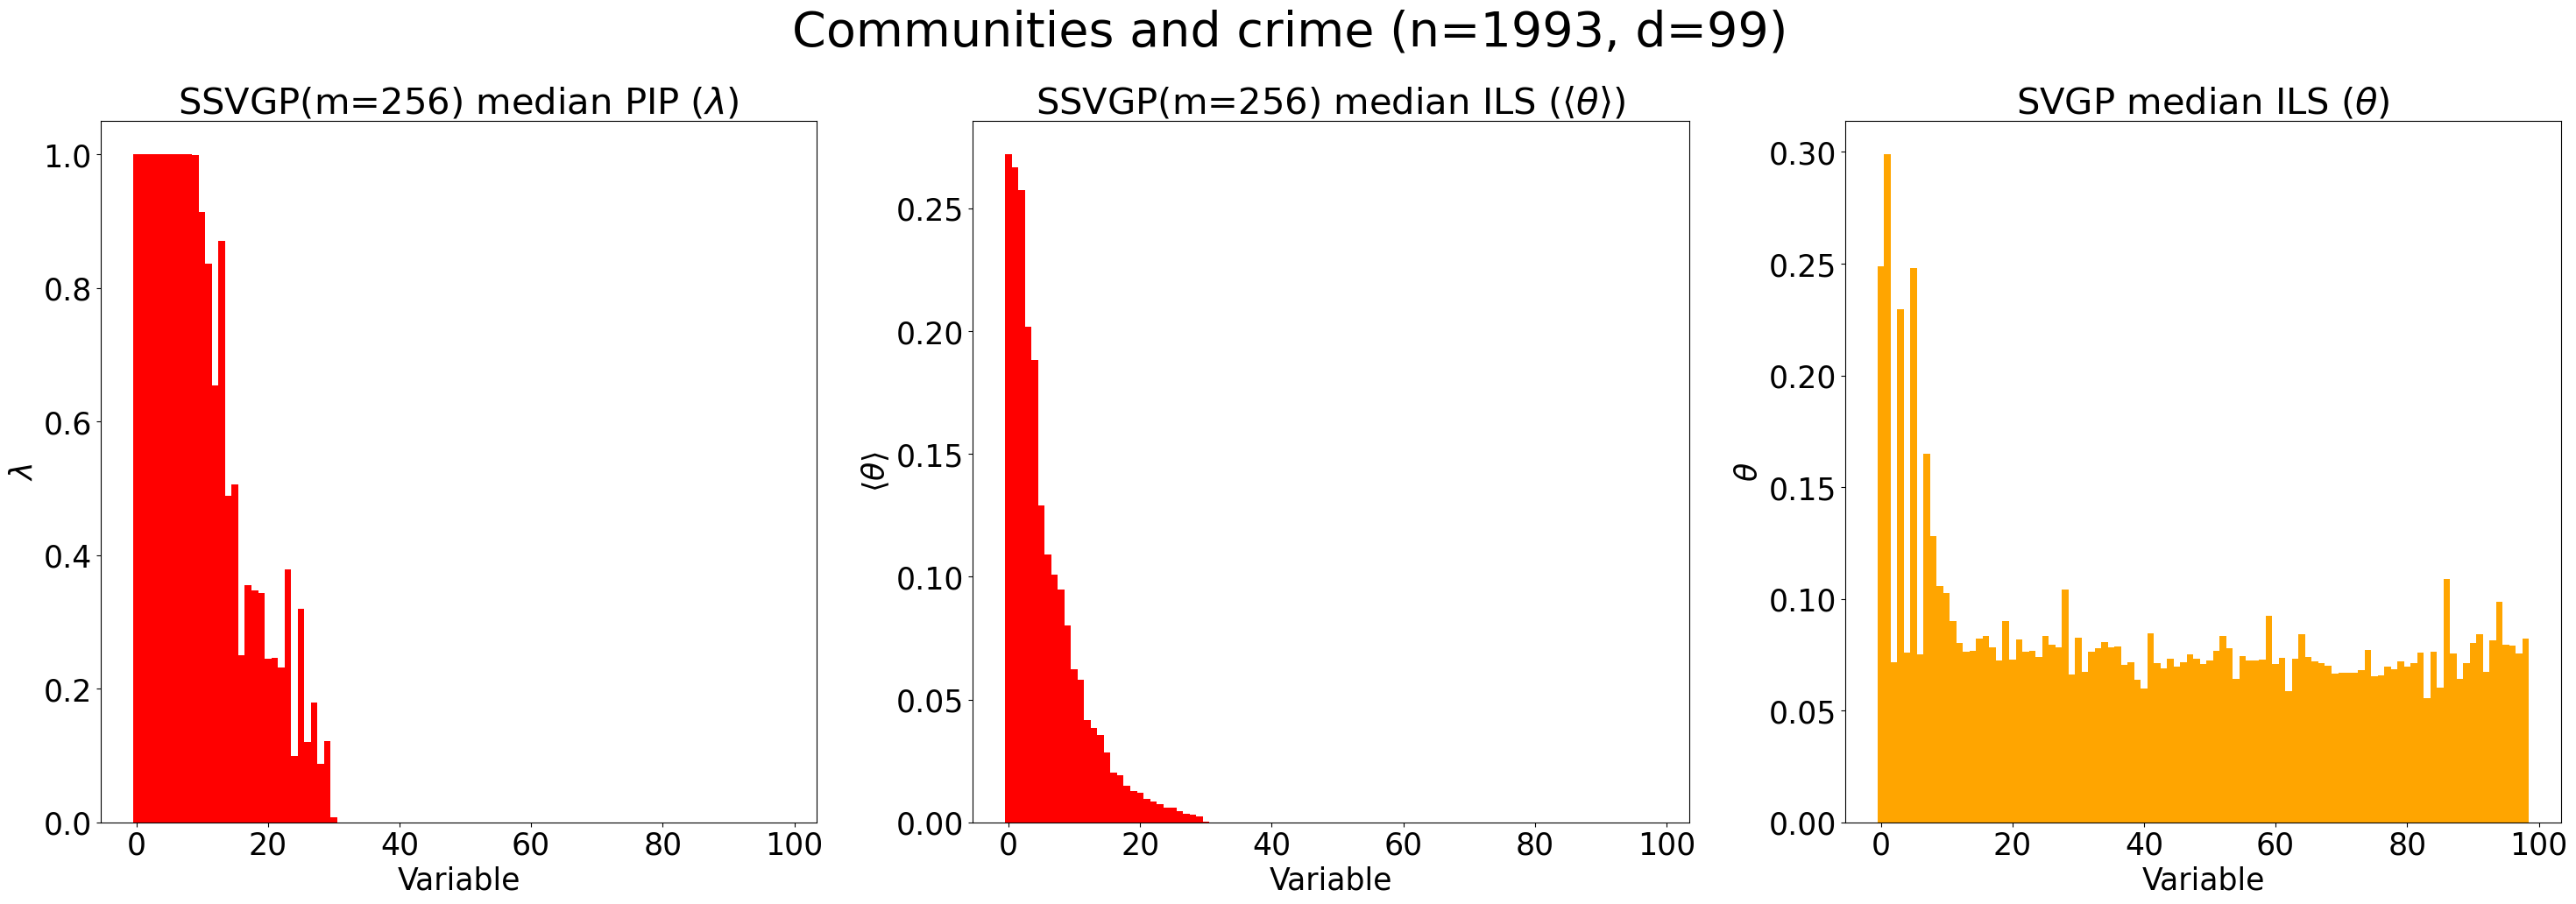

In [95]:
"""
Displaying learned PIPs
"""
runs = np.linspace(0,9,10).astype(int)
from matplotlib import rcParams, rc_file_defaults
rc_file_defaults()
plt.rc('axes',edgecolor='black')
font = {'size'   : 25}
plt.rc('font', **font)
plt.rcParams.update({'text.color' : "black",
                      'xtick.color' : "black",
                      'ytick.color' : "black",
                     'axes.labelcolor' : "black"})

w=1
order = np.argsort(np.median(np.abs(Data["L"][runs,2]),0))[::-1]

fig,axs = plt.subplots(1,3, figsize = (30,10))
fig.set_facecolor('white')
fig.suptitle("Communities and crime (n=1993, d=99)", y=1.05, fontsize = 40)
axs[0].set_facecolor('white')
axs[1].set_facecolor('white')
axs[2].set_facecolor('white')
axs[0].bar(range(d), np.median(np.abs(Data["Lambda"][runs,2]),0)[order],width = w, color = "red")
axs[0].set_title(r"SSVGP(m=256) median PIP $(\lambda)$")
axs[0].set_xlabel("Variable")
axs[0].set_ylabel(r"$\lambda$")
axs[1].bar(range(d), np.median(np.abs(Data["L"][runs,2]),0)[order], width = w, color = "red")#, yerr = np.var(np.abs(Data["L"][:,3]),0)[order]**0.5)
axs[1].set_title(r"SSVGP(m=256) median ILS $(\langle \theta \rangle) $")
axs[1].set_xlabel("Variable")
axs[1].set_ylabel(r"$\langle \theta \rangle $")
axs[2].bar(range(d),np.median(np.abs(Data["L"][runs,1]),0)[order], width=w, color = "orange")#, yerr = np.var(np.abs(Data["L"][:,6]),0)[order]**0.5)
axs[2].set_title(r"SVGP median ILS $(\theta)$")
axs[2].set_xlabel("Variable")
axs[2].set_ylabel(r"$\theta$")
plt.tight_layout()
plt.show()
fig.savefig("Communities_plots",bbox_inches = 'tight')

In [75]:
"""
Creating table for mean pm sd plots
"""
# Threshold and dimension choice (first element depends on best performing threshold)
nmodel = len(names)

#Column-names to fetch information from dictionary
Metrics = ["MSE", "Runtime"]

# Empty table
Table = np.zeros((nmodel, 10,3))

# Filling table
for i in range(len(Metrics)):
    Table[:,:,i] = Data[Metrics[i]].T
    Table[:,:,2] = np.sum(Data["Lambda"]>0.01,2).T
    Table[:2,:,2]= d

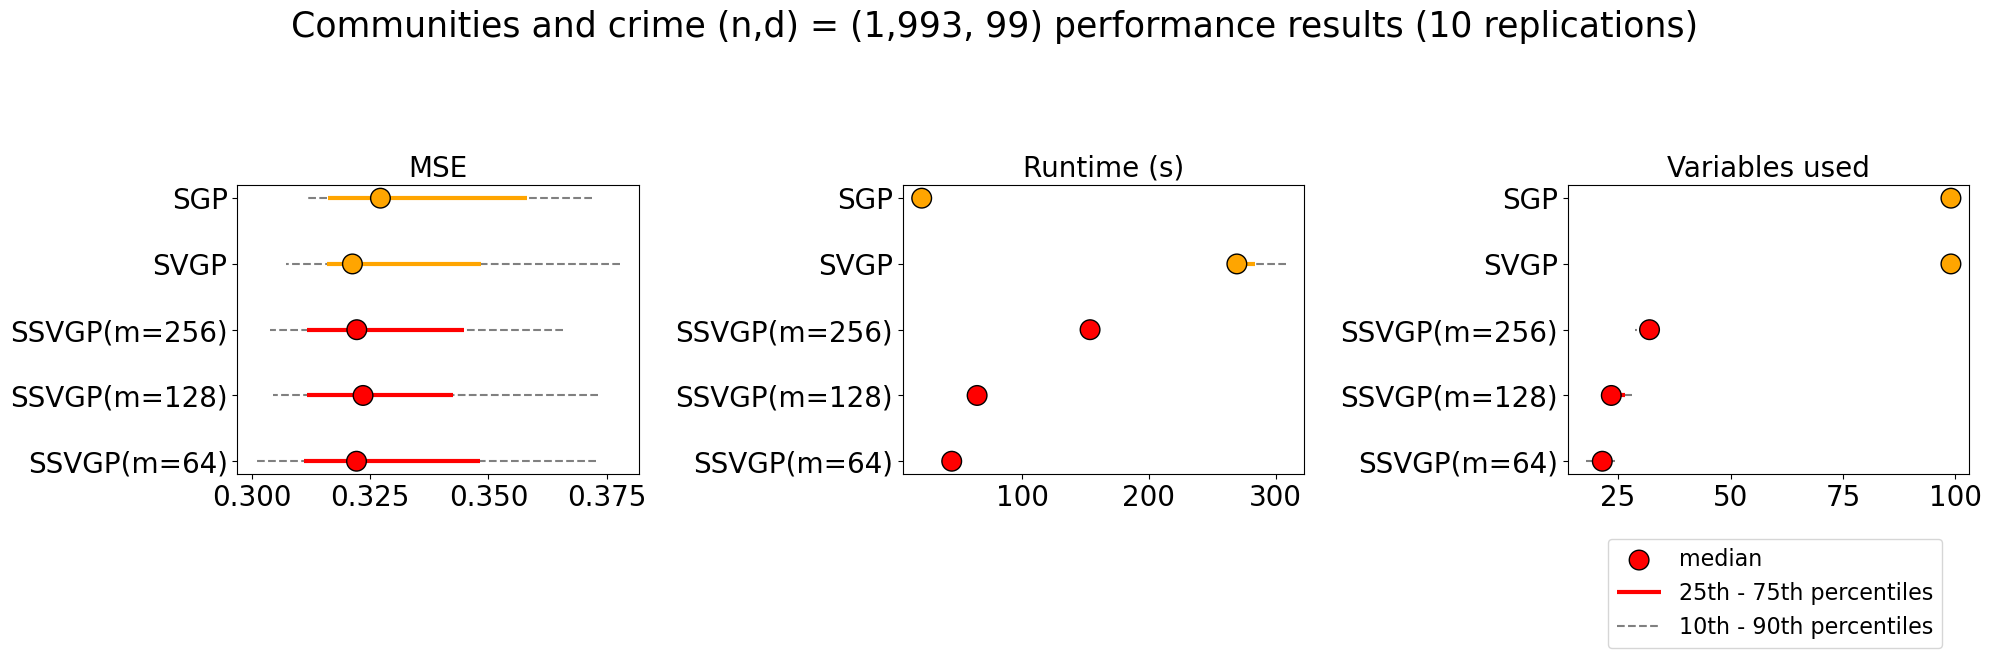

In [96]:
"""
Mean and sd plot
"""
plt.rc('axes',edgecolor='black')
font = {'family' : 'normal',
        'size'   : 32}
plt.rc('font', **font)

inds = [1,2,3,4,5]
c1 = "red"
c1b = "orange"
c2 = "grey"
c3 = "lightgrey"
colours = [np.concatenate((np.repeat(c1,3),np.repeat(c1b,2))),np.repeat(c2,5),np.repeat(c3,5)]
xlim = [(0.1,0.25), (0.5,1.01), (2,100)]
quantiles = [0.75,0.9,0.99]
linestyles = ["-", "--","--"]
lws = [3,1.5,1.5]

# Creating plots of results
from matplotlib import rcParams, rc_file_defaults
Metric_names = ["MSE", "Runtime (s)", "Variables used"]
labelsize = 20
rc_file_defaults()
rcParams['xtick.labelsize'] = labelsize
rcParams['ytick.labelsize'] = labelsize 

fig,axs = plt.subplots(nrows=1, ncols=3, figsize = (20,6.5))
fig.suptitle(r" Communities and crime (n,d) = (1,993, 99) performance results (10 replications) ", fontsize = 25, y = 1.2)
for i in range(np.shape(Table)[2]):
    axs[i].set_title(Metric_names[i], Fontsize = 20)
    axs[i].set_yticks(inds[::-1])
    means = np.median(Table[:,:,i],1)[::-1]
    sd = np.var(Table[:,:,i],1)[::-1]**0.5
    axs[i].set_yticklabels(names)
    axs[i].scatter(means,inds, color = np.concatenate((np.repeat("red",3),np.repeat("orange",2))), s = 200, label = "median",zorder = 12, edgecolors = "black")
    for j in range(2):
        upper = np.quantile(Table[:,:,i],quantiles[j],1)[::-1]
        lower = np.quantile(Table[:,:,i],1-quantiles[j],1)[::-1]
        axs[i].hlines(inds, upper, lower, color=colours[j], linestyle=linestyles[j], lw=lws[j], 
                      label = "{0}th - {1}th percentiles".format(int(100-quantiles[j]*100), int(quantiles[j]*100)),
                    zorder = 10-3*j)
plt.legend(fontsize=16, loc = (0.1,-0.6))
plt.tight_layout()
plt.show()
fig.savefig("Communities_performance_plots", bbox_inches = "tight")